# Readout simulation

## Initialization

In [68]:
import readout as RO
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import ode, quad
from scipy.stats import norm
import numpy as np
from numpy import random

### - System parameters

In [69]:
g = 45e6 # Transmon-cavity coupling strength (Hz)
delta = 380e6*5 # Transmon-cavity detuning (0z)
chi = 2*np.pi*g**2/delta
kappa = chi
T1e = 1e-5   # Characteristic time of e -> g transmon transition 
T1g = 1   # Characteristic time of g -> e transmon transition 

In [146]:
kappa/2/np.pi/1e6

1.0657894736842106

### - Simulation parameters

In [105]:
alpha_0 = 0   # Initial cavity state
t_sim = 47530e-10 # Simulation time > 20/chi
dt = 1e-11   # Simulation timestep

freq_mm = 0   # Frequency mismatch between input signal and cavity (Hz)
A = 3   # Input signal amplitude

# Input signal (square pulse)
def b_in(t):

    # Pulse start time
    t0 = 10e-9
    
    # Pulse stop time
    tf = 1000e-9
    
    if t > t0 and t < tf:
        return A*np.exp(1j*2*np.pi*freq_mm*t)

    else:
        return 0 

## Readout dynamics
Instantiation of readout_simulation object

In [106]:
sim = RO.readout_simulation(b_in, freq_mm, chi, kappa, T1e, T1g, alpha_0, t_sim, dt)

# Dynamics when transmon is in excited state (q_state = 1)
q_state = 1
b_out_e, cavity_alpha_e, t_rng = sim.simulate_cavity_dynamics(q_state)

# Dynamics when transmon is in ground state (q_state = 0)
q_state = 0
b_out_g, cavity_alpha_g, t_rng = sim.simulate_cavity_dynamics(q_state)

### - Input signal plot
sim.b_int(t)

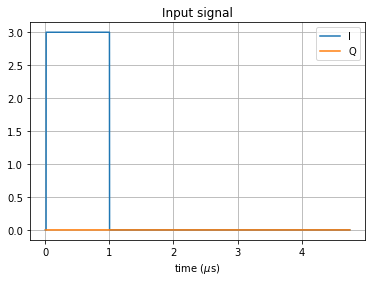

In [107]:
fig, ax = plt.subplots()

ax.plot([t*1e6 for t in t_rng], [sim.b_in(t).real for t in t_rng], label = 'I')
ax.plot([t*1e6 for t in t_rng], [sim.b_in(t).imag for t in t_rng], label = 'Q')
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Input signal')
ax.grid()
ax.legend()

plt.show()

### - Cavity state plot
sim.cavity_alpha

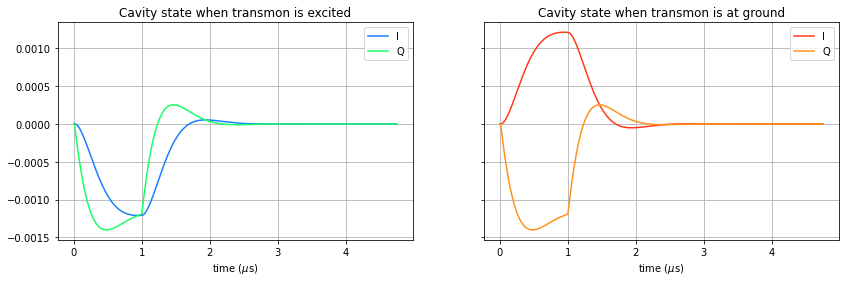

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot([t*1e6 for t in t_rng], [x.real for x in cavity_alpha_e], label = 'I', c = '#177FFF')
ax1.plot([t*1e6 for t in t_rng], [x.imag for x in cavity_alpha_e], label = 'Q', c = '#17FF64')
ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Cavity state when transmon is excited')
ax1.grid()
ax1.legend()

ax2.plot([t*1e6 for t in t_rng], [x.real for x in cavity_alpha_g], label = 'I', c = '#FF3A17')
ax2.plot([t*1e6 for t in t_rng], [x.imag for x in cavity_alpha_g], label = 'Q', c = '#FF9317')
ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Cavity state when transmon is at ground')
ax2.grid()
ax2.legend()

plt.show()

### - Output signal plot
sim.b_out

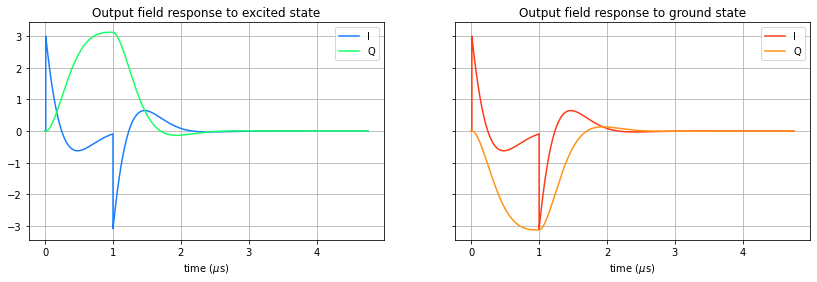

In [109]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot([t*1e6 for t in t_rng], [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot([t*1e6 for t in t_rng], [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax2.plot([t*1e6 for t in t_rng], [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot([t*1e6 for t in t_rng], [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')

ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Output field response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Output field response to ground state')
ax2.grid()
ax2.legend()

plt.show()

## Noisy acquisition of output signal
sim.b_signal_proc() function

In [141]:
# Measurement parameters
t_wait = 3/kappa    # waiting time
t_acq = 700e-9    # sampling time
dt_acq = 20e-9    # sampling interval

acq_b_out_e, dsp_b_out_e, noisy_dsp_b_out_e, acq_time = sim.digital_signal_processing(b_out_e, t_rng, t_wait, t_acq, dt_acq)
acq_b_out_g, dsp_b_out_g, noisy_dsp_b_out_g, acq_time = sim.digital_signal_processing(b_out_g, t_rng, t_wait, t_acq, dt_acq)

### - Acquisition of b_out and plot in IQ plane
acq_b_out

C:\Users\qcrew\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


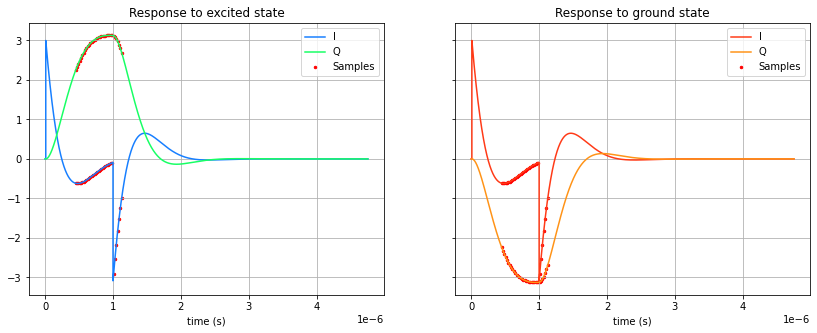

In [142]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(14,5))

ax1.plot(t_rng, [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot(t_rng, [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax1.scatter(acq_time, [x.real for x in acq_b_out_e], c = 'r', label = 'Samples', s = 6)
ax1.scatter(acq_time, [x.imag for x in acq_b_out_e], c = 'r', s = 6)

ax2.plot(t_rng, [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot(t_rng, [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')
ax2.scatter(acq_time, [x.real for x in acq_b_out_g], c = 'r', label = 'Samples', s = 6)
ax2.scatter(acq_time, [x.imag for x in acq_b_out_g], c = 'r', s = 6)

ax1.set_xlabel('time (s)')
ax1.set_title('Response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time (s)')
ax2.set_title('Response to ground state')
ax2.grid()
ax2.legend()

plt.show()

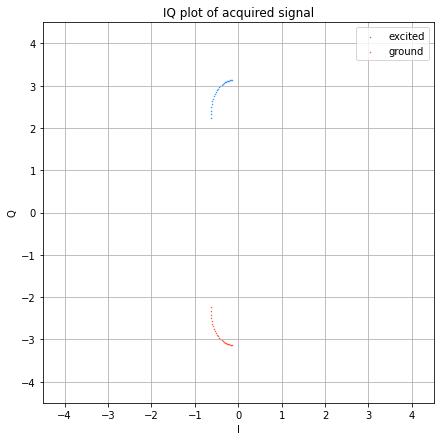

In [133]:
f, ax = plt.subplots(figsize=(7,7))

ax.scatter([x.real for x in acq_b_out_e], [x.imag for x in acq_b_out_e], label = 'excited', c = '#177FFF', s = 0.2)
ax.scatter([x.real for x in acq_b_out_g], [x.imag for x in acq_b_out_g], label = 'ground', c = '#FF3A17', s = 0.2)

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.set_title('IQ plot of acquired signal')
ax.legend()
ax.grid()

plt.show()

### - Removal of frequency mismatch from acquired b_out and plot in IQ plane
proc_b_out

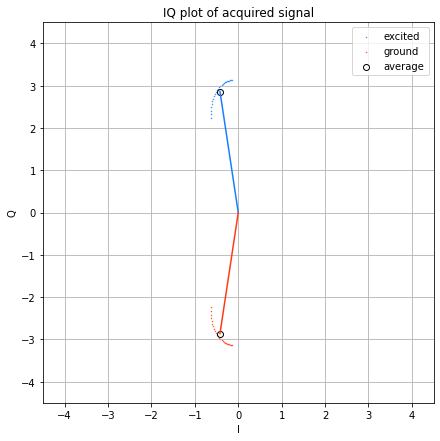

In [135]:
f, ax = plt.subplots(figsize=(7,7))

# Plot noisy data
b_avg_e = np.mean(dsp_b_out_e)
b_avg_g = np.mean(dsp_b_out_g)

ax.scatter([x.real for x in dsp_b_out_e], [x.imag for x in dsp_b_out_e], label = 'excited', c = '#177FFF', s = 0.2)
ax.scatter([x.real for x in dsp_b_out_g], [x.imag for x in dsp_b_out_g], label = 'ground', c = '#FF3A17', s = 0.2)

ax.plot([0, b_avg_e.real], [0, b_avg_e.imag], c = '#177FFF')
ax.scatter([b_avg_e.real], [b_avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, b_avg_g.real], [0, b_avg_g.imag], c = '#FF3A17')
ax.scatter([b_avg_g.real], [b_avg_g.imag], edgecolors = 'k', c = 'w', label = 'average')

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.set_title('IQ plot of acquired signal')
ax.legend()
ax.grid()

plt.show()

### - IQ plane plot of post-processed b_out with addition of noise 
noisy_proc_b_out

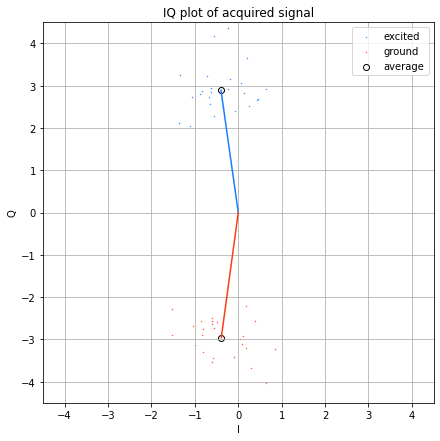

In [136]:
f, ax = plt.subplots(figsize=(7,7))

# Plot noisy data
noisy_avg_e = np.mean(noisy_dsp_b_out_e)
noisy_avg_g = np.mean(noisy_dsp_b_out_g)

ax.scatter([x.real for x in noisy_dsp_b_out_e], [x.imag for x in noisy_dsp_b_out_e], label = 'excited', c = '#177FFF', s = 0.2)
ax.scatter([x.real for x in noisy_dsp_b_out_g], [x.imag for x in noisy_dsp_b_out_g], label = 'ground', c = '#FF3A17', s = 0.2)

ax.plot([0, noisy_avg_e.real], [0, noisy_avg_e.imag], c = '#177FFF')
ax.scatter([noisy_avg_e.real], [noisy_avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, noisy_avg_g.real], [0, noisy_avg_g.imag], c = '#FF3A17')
ax.scatter([noisy_avg_g.real], [noisy_avg_g.imag], edgecolors = 'k', c = 'w', label = 'average')

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.set_title('IQ plot of acquired signal')
ax.legend()
ax.grid()

plt.show()

## Theta estimation
sim.theta_estimation() function

In [137]:
theta_out_e, int_theta_out_e, theta_estimate_e, est_q_state_e, acq_time = sim.theta_estimation(noisy_dsp_b_out_e, dt_acq)
theta_out_g, int_theta_out_g, theta_estimate_g, est_q_state_g, acq_time = sim.theta_estimation(noisy_dsp_b_out_g, dt_acq)

### - Histogram of acquired noisy phase values and fit to gaussian
theta_out

Expected from theory:
mu_e: 90.00°, std_e: 9.55°
mu_g: -90.00°, std_g: 9.55°

Estimation from collected data:
mu_e: 98.10°, std_e: 11.62°
mu_g: -97.93°, std_g: 11.90°


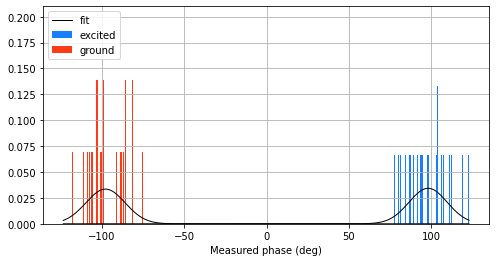

In [138]:
f, ax = plt.subplots(figsize=(8, 4))
noisy_theta_e = theta_out_e
noisy_theta_g = theta_out_g

# Fit data to normal distribution
mu_e, std_e = norm.fit(noisy_theta_e)
mu_g, std_g = norm.fit(noisy_theta_g)

binwidth = 0.6
lim_min = np.ceil(np.array(noisy_theta_e + noisy_theta_g).min() / binwidth) * binwidth
lim_max = np.ceil(np.array(noisy_theta_e + noisy_theta_g).max() / binwidth) * binwidth
bins = np.arange(lim_min, lim_max + binwidth, binwidth)

ax.hist(noisy_theta_e, density=True, color = '#177FFF', bins=bins, label = 'excited')
ax.hist(noisy_theta_g, density=True, color = '#FF3A17', bins=bins, label = 'ground')

x = np.linspace(lim_min, lim_max, 500)
p_e = norm.pdf(x, mu_e, std_e)
plt.plot(x, p_e, 'k', linewidth=1., label = 'fit')
p_g = norm.pdf(x, mu_g, std_g)
plt.plot(x, p_g, 'k', linewidth=1.)

print('Expected from theory:')
print('mu_e: %.2f°, std_e: %.2f°' % (sim.exp_theta['e'], 180/np.pi*np.sqrt(1/4/np.absolute(A**2))))
print('mu_g: %.2f°, std_g: %.2f°\n' % (sim.exp_theta['g'], 180/np.pi*np.sqrt(1/4/np.absolute(A**2))))

print('Estimation from collected data:')
print('mu_e: %.2f°, std_e: %.2f°' % (mu_e, std_e))
print('mu_g: %.2f°, std_g: %.2f°' % (mu_g, std_g))

plt.xlabel('Measured phase (deg)')

plt.legend()
plt.grid()
plt.show()

### - Integrated noisy phase values and comparison to expected values
int_theta_out 

sim.exp_theta

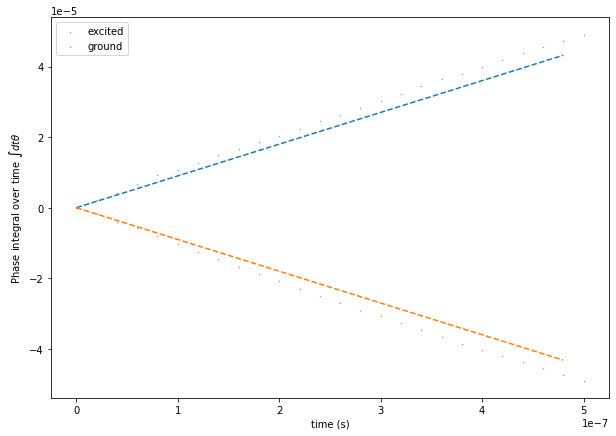

In [139]:
f, ax = plt.subplots(figsize=(10,7))

ax.scatter(acq_time + [dt_acq*len(acq_time)], int_theta_out_e, label = 'excited', c = '#177FFF', s = 0.1)
ax.scatter(acq_time + [dt_acq*len(acq_time)], int_theta_out_g, label = 'ground', c = '#FF3A17', s = 0.1)

# Plot theoretical expected values of integrated theta
ax.plot(acq_time, [sim.exp_theta['e']*dt_acq*i for i in range(len(acq_time))], linestyle = '--')
ax.plot(acq_time, [sim.exp_theta['g']*dt_acq*i for i in range(len(acq_time))], linestyle = '--')

plt.ylabel(r"Phase integral over time $\int dt{\theta}$")
plt.xlabel('time (s)')
plt.legend()
plt.show()

### - Final theta estimation
theta_estimate

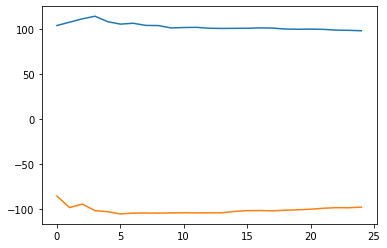

In [140]:
plt.plot(theta_estimate_e)
plt.plot(theta_estimate_g)
plt.show()